<a href="https://colab.research.google.com/github/emrullahozkilinc/machine-learning/blob/master/svm_statquest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

In [2]:
#Veri setinin eklenmesi
url="https://raw.githubusercontent.com/emrullahozkilinc/machine-learning/master/dataset/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

Veri seti hakkında bilgi için:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [5]:
df['PAY_0'].unique()

array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6])

In [6]:
#Hedef kolon ismi uzun olduğundan ismini DEFAULT olarak değiştirilmesi.
df.rename({'default payment next month' : 'DEFAULT'}, axis="columns", inplace=True)

In [7]:
#ID kolonunun işe yaramadığı için silinmesi.
df.drop("ID", axis='columns', inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
#EDUCATION ve MARRIAGE kolonlarındaki missing valueların hesaplanması
len(df.loc[(df['EDUCATION']==0) | (df['MARRIAGE']==0)])

68

In [9]:
#İki kolondada missing value olmayan tüm satırların alınması.
df_no_missing = df.loc[(df['EDUCATION']!=0) & (df['MARRIAGE']!=0)]
len(df_no_missing)

29932

In [10]:
#Default=0 ve Default=1 olanların ayrılması.
df_default = df_no_missing[df_no_missing['DEFAULT']==1]
df_no_default = df_no_missing[df_no_missing['DEFAULT']==0]

print(len(df_default))
print(len(df_no_default))

6631
23301


In [11]:
#Her biri için 1000'er rasgele örnek alınması
df_default_resampled = resample(df_default, replace=False, n_samples=1000)
df_no_default_resampled = resample(df_no_default, replace=False, n_samples=1000)

print(len(df_default_resampled))
print(len(df_no_default_resampled))

1000
1000


In [12]:
#Alınan örneklerin tek bir dataframe'de birleştirilmesi
df_resampled = pd.concat([df_default_resampled,df_no_default_resampled])
len(df_resampled)

2000

In [13]:
#test edilecek verilerden hedef kolonun silinmesi.
X = df_resampled.drop(['DEFAULT'],axis='columns').copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
19693,70000,2,2,1,49,0,0,0,0,0,0,64049,66079,67488,58246,48859,46688,3700,3100,2200,1600,1850,1800
21723,50000,2,2,2,23,0,0,0,0,-1,0,97259,50017,48560,46978,19640,18937,3608,2110,2558,19640,683,699
17575,170000,2,2,1,40,2,-1,2,-1,-1,-1,193,3760,3500,7190,9000,0,3760,0,7190,9000,0,0
24710,30000,1,3,2,33,0,0,0,0,0,0,30384,30134,30646,29657,30232,28415,3010,3000,3000,3000,1083,0
23361,350000,2,2,2,28,1,2,0,0,0,0,358895,346575,345088,341811,265953,93300,0,14579,13557,12000,5000,11000


In [14]:
#Hedef kolonun değişkene atanması
y = df_resampled['DEFAULT'].copy()

In [15]:
#Modelin train edilebilmesi için one-hot-encoding yapılması.
encode_columns = ['SEX','EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
X_encoded = pd.get_dummies(X, columns=encode_columns)

In [16]:
#Verinin train-test'e bölünmesi ve scale edilmesi.
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, random_state=42)
X_train_scaled=scale(X_train)
X_test_scaled=scale(X_test)

In [17]:
#Modelin hazırlanması
clsf_svm = SVC()
clsf_svm.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

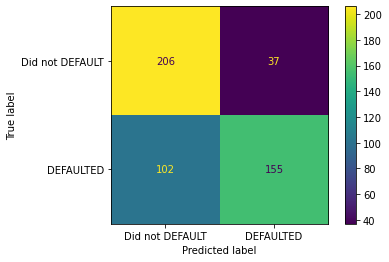

In [18]:
#Confussion matrix'in hesabı
plot_confusion_matrix(clsf_svm, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Did not DEFAULT','DEFAULTED'])

In [19]:
#Optimizasyon hiperparametrelerinin belirlenmesi
hiper_params=[
  {'C' : [0.5, 1, 10, 100],
   'gamma' : ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
   'kernel' : ['rbf']},
]

In [20]:
#Parametre optimizasyonu

optimized_params = GridSearchCV(
    SVC(),          
    hiper_params,   
    cv=5,                 #Cross Validation 5 belirlendi.
    scoring='accuracy',
    verbose=2
)

optimized_params.fit(X_train_scaled, y_train)
print(optimized_params.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.5, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................... C=0.5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.5, gamma=1, kernel=rbf, total=   0.3s
[CV] C=0.5, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.5, gamma=1, kernel=rbf, total=   0.3s
[CV] C=0.5, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.5, gamma=1, kernel=rbf, total=   0.3s
[CV] C=0.5, gamma=1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   28.2s finished


{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [28]:
#Belirlenen parametreler ile modelin eğitilmesi
clsf_svm = SVC(C=1, gamma=0.01)
clsf_svm.fit(X_train_scaled, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

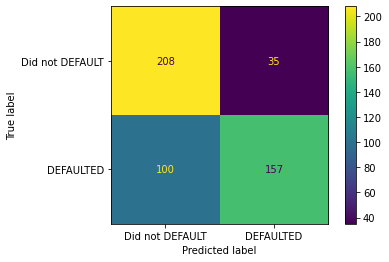

In [29]:
#Optimize edilmiş modelin tablosunun çizdirilmesi

plot_confusion_matrix(clsf_svm,
                      X_test_scaled,
                      y_test,
                      display_labels = ['Did not DEFAULT', 'DEFAULTED'],
                      values_format='d')

In [23]:
#PCA Optimizasyonu

pca = PCA()
X_trained_PCA = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

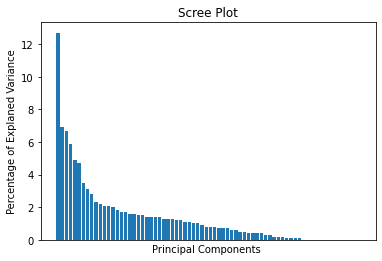

In [24]:
#PCA'nın çizdirilmesi

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    labelbottom=False,
    top=False)

plt.ylabel('Percentage of Explaned Variance')
plt.xlabel('Principal Components ')
plt.title('Scree Plot')

plt.show()

In [25]:
#PCA'nın uygulanarak tekrardan hesap yapılması.

train_pc1_coor = X_trained_PCA[:, 0]
train_pc2_coor = X_trained_PCA[:, 1]

PCA_train_scaled = scale(np.column_stack((train_pc1_coor, train_pc2_coor)))

param_grid=[
   {'C' : [1, 10, 100, 1000],
    'gamma' : ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel' : ['rbf']},
]
    
optimal_values = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2
)

optimal_values.fit(PCA_train_scaled, y_train)
print(optimal_values.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=1, gamma=scale, kernel=rbf, total=   0.0s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... C=1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   15.3s finished


In [30]:
#Hesaplanan değerlerlerle modelin tekrardan eğitilmesi

optimized_svc=SVC(C=100, gamma='scale')
optimized_svc.fit(PCA_train_scaled, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Text(0.5, 1.0, 'Decision surface using the PCA transformed features')

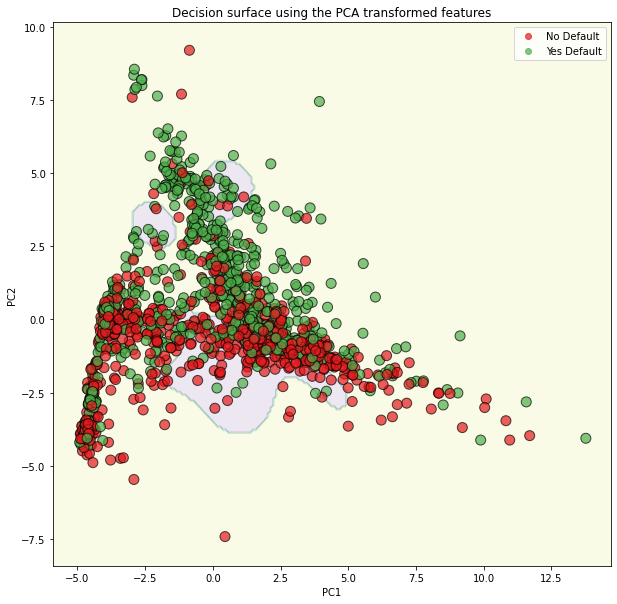

In [42]:
#Sonuçların çizdirilmesi.

X_test_PCA=pca.transform(X_train_scaled) 

#PCA sonuçlarına göre en iyi iki kolonunu alınması.
test_pc1_coor = X_test_PCA[:, 0]
test_pc2_coor = X_test_PCA[:, 1]

#Alınan değerlere göre grafik sınırlarının belirlenmesi
x_min = test_pc1_coor.min()-1
x_max = test_pc1_coor.max()+1

y_min = test_pc2_coor.min()-1
y_max = test_pc2_coor.max()+1

#Belirlenen sınırlara göre grafiğin çizdirilmesi.
xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

#Oluşturulan modelden koordinatlar kullanılarak tahmin yapılması.
Z = optimized_svc.predict(np.column_stack((xx.ravel(),yy.ravel())))

Z = Z.reshape(xx.shape)

#Çizimin yapılması
fig, ax = plt.subplots(figsize=(10,10))             #Boyutların belirtilmesi
ax.contourf(xx, yy, Z, alpha=0.1)                   #Noktaların çizilmesi
cmap = clr.ListedColormap(['#e41a1c','#4daf4a'])  #Renklerin belirtilmesi
scatter = ax.scatter(test_pc1_coor, test_pc2_coor,
                     c=y_train, cmap=cmap, s=100,
                     edgecolors='k', alpha=0.7)

legend = ax.legend(scatter.legend_elements()[0],
                   scatter.legend_elements()[1],
                   loc='upper right')

legend.get_texts()[0].set_text('No Default')
legend.get_texts()[1].set_text('Yes Default')

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using the PCA transformed features')